# Derive Statistical Tests from the Descriptor-Based Neural Network Classifier <a class="tocSkip">

## Set up the Environment

In [1]:
# Import everything that's needed to run the notebook
import os
import pickle
import pathlib
import datetime
import random
import datetime as dt

from IPython.display import display, Markdown, Latex
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
import sklearn.metrics
import sklearn.preprocessing
from scipy.stats import shapiro
import matplotlib.pyplot as plt
import boruta
from scipy.stats import gaussian_kde
import warnings

import util
from ipynb.fs.defs.descriptor_based_neural_networks import DescriptorBuilder, prepare_input, traverse_and_save

warnings.simplefilter('ignore')

plt.rc('xtick',labelsize=13)
plt.rc('ytick',labelsize=13)

Read the configuration.

In [2]:
# Define the path to the configuration dictionary
config_path = 'configuration.p'

# Load the configuration dictionary
with open(config_path, 'rb') as f:
    configuration = pickle.load(f)
    
# Get the paths to the relevant directories 
data_directory_path = configuration['data']['directory_path']
classifiers_directory_path = configuration['classifiers']['directory_path']
tests_directory_path = configuration['tests']['directory_path']

# Get the parameters of the experiment
cv_folds = configuration['experiment']['number_of_cv_folds']

In [3]:
reports = {}

## Load the Classifier

In [4]:
with open(os.path.join(classifiers_directory_path, 'dbnn_classifier.p'), 'rb') as f:
    dbnn = pickle.load(f)

## Prepare the data

Load the data.

In [5]:
# Define the dictionary to store the actual datasets, indexed by their names
datasets = {}

# Load the datasets
for set_name in ['E', 'D', 'C-G1', 'C-G2', 'C-G3', 'C-G4', 'A']: #configuration['data']['datasets']:
    set_path = configuration['data']['datasets'][set_name]['path']
    print('Loading {} from {}'.format(set_name, set_path))
    datasets[set_name] = util.load_from_file(set_path)
    print('Done.')

Loading E from data/E.data
Done.
Loading D from data/D.data
Done.
Loading C-G1 from data/C-G1.data
Done.
Loading C-G2 from data/C-G2.data
Done.
Loading C-G3 from data/C-G3.data
Done.
Loading C-G4 from data/C-G4.data
Done.
Loading A from data/A.data
Done.


Split the labels from the samples to ease future manipulation. Split $\mathcal{E}$ into two equal parts.

In [6]:
chosen_sets = list(datasets.keys())

for set_name in chosen_sets:
    labels = [sample.pop() for sample in datasets[set_name]]
    samples = datasets[set_name]
    
    if set_name == 'E':
        stratify = [str(label) + str(len(sample)) for (label, sample) in zip(labels, samples)]
        samples_1, samples_2, labels_1, labels_2 = train_test_split(samples, labels, train_size=0.5, stratify=stratify)
        datasets['E1'] = {'samples' : samples_1, 'labels' : labels_1}
        datasets['E2'] = {'samples' : samples_2, 'labels' : labels_2}
    else:
        datasets[set_name] = {'samples' : samples, 'labels' : labels}
    
del datasets['E']

chosen_sets = list(datasets.keys())

## Define the Statistic
Define the statistic as the net's final layer's output. Refer to the statistic as $T$ from now on.

In [7]:
def dbnn_statistic_function(samples):
    prepared_samples = prepare_input(samples, dbnn)
    activations = util.get_activations(dbnn['neural_net'], prepared_samples)
    return activations[-1]

### Visualize the Statistic's Distribution

First, define a function that performs visualization.

In [8]:
def visualize_statistics(samples, labels, statistic_function, xlim=None, ylim=None, 
                         colors=['crimson', 'navy'], ylabel='density', xlabel='Statistic'):
    results = pd.DataFrame({
        'n' : [len(sample) for sample in samples],
        'label' : [int(label) for label in labels],
        'statistic' : statistic_function(samples).ravel(),
    })
    
    fig = plt.figure(figsize=(10, 7))
    
    if xlim is not None:
        plt.xlim(*xlim)
    
    if ylim is not None:
        plt.ylim(*ylim)

    for label in [0, 1]:
        mask = (results['label'] == label)
        results[mask]['statistic'].plot(kind='density', label='$f_{}$'.format(label),
                                      color=colors[label], linewidth=3)

    plt.ylabel(ylabel, fontsize=16)
    plt.xlabel(xlabel, fontsize=16)
    plt.legend(fontsize=16)
    
    return fig

Apply it.

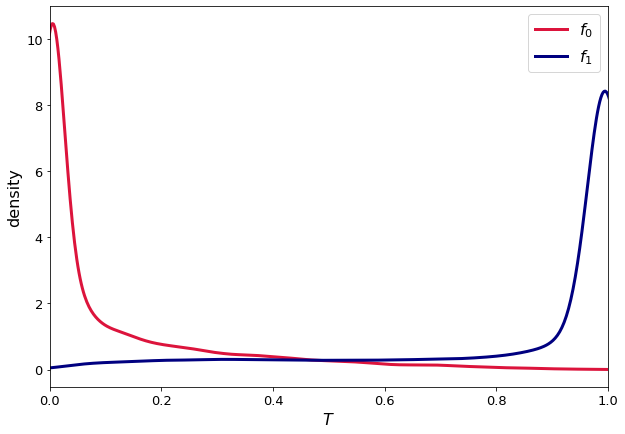

In [9]:
fig = visualize_statistics(datasets['E1']['samples'],
                           datasets['E1']['labels'],
                           dbnn_statistic_function, xlim=(0, 1),
                           xlabel='$T$', ylabel='density')

In [10]:
reports['T_statistic_fig'] = fig

## Create the  Tests

Define the basic class of the binary tests. Its main functionalities are the methods for calculating the $p$-values.

In [11]:
class FrequentistTest(object):
    def __init__(self):
        pass
    
    def quantify_uncertainty(self, sample):
        pass

class OneStatisticTest(FrequentistTest):
    def __init__(self, samples, statistic_function, lower_is_more_extreme=True, adapt_to_size=False):
        super(OneStatisticTest, self).__init__()
        self.statistic_function = statistic_function
        self.statistics = np.sort(statistic_function(samples)).squeeze()
        self.lower_is_more_extreme = lower_is_more_extreme
        self.adapt_to_size = adapt_to_size
        
        if adapt_to_size:
            sizes = np.array([len(sample) for sample in samples])
            self.__prepare_statistics_by_sample_size(self.statistics, sizes)
        
    def __prepare_statistics_by_sample_size(self, statistics, sizes):
        by_sample_size = {}
        for size in np.unique(sizes):
            selected_statistics = statistics[sizes == size].squeeze()
            by_sample_size[size] = np.sort(selected_statistics).squeeze()
        self.statistics_by_size = by_sample_size 
    
    def p_value(self, sample):
        [sample_statistic] = self.statistic_function([sample])
        
        n = len(sample)
        
        if self.adapt_to_size == False or n not in self.statistics_by_size.keys():
            statistics = self.statistics
        else:
            statistics = self.statistics_by_size[n]
        
        total_count = len(statistics)
        
        if self.lower_is_more_extreme:
            [i] = np.searchsorted(statistics, sample_statistic, side='right')
            more_extreme_count = i
        else:
            [i] = np.searchsorted(statistics, sample_statistic, side='left')
            more_extreme_count = total_count - i + 1

        return more_extreme_count / total_count
    
    def calculate_statistic(self, sample):
        return self.statistic_function([sample])
    
    def quantify_uncertainty(self, sample):
        return self.p_value(sample)

Create the tests.

In [12]:
n = len(datasets['E1']['samples'])
normal_samples = [datasets['E1']['samples'][i] for i in range(n) if datasets['E1']['labels'][i] == 1]
nonnormal_samples = [datasets['E1']['samples'][i] for i in range(n) if datasets['E1']['labels'][i] == 0]

fisher_test_1 = OneStatisticTest(normal_samples, dbnn_statistic_function, adapt_to_size=True)
fisher_test_0 = OneStatisticTest(nonnormal_samples, dbnn_statistic_function, lower_is_more_extreme=False, adapt_to_size=True)

fisher_tests = [fisher_test_0, fisher_test_1]

### Inspect the $p$-values

The $p$-values are calculated using the set $\mathcal{E}_1$. We can check their properties using the set $\mathcal{E}_2$. Those properties are:
- The types of their distributions over normal and non-normal samples.
- Boundedness from above for the samples from the same distribution for which the $p$ value is calculated. More specifically:
$$P\left(p_c(T(\mathbf{x}) \leq \alpha \right) \leq \alpha \qquad 0 \leq \alpha \leq 1,\quad y(\mathbf{x})=c,\quad c \in\{0,1\}$$ *Note: The probability $P$ should be interpreted in the frequentist way, as the long-term frequency*.
- Asymptotically decreasing to zero for the samples from the opposite class as the sample size grows.

### Inspect the Relationship between the $p$-values and Statistics

Check the distributions of the $p$-values for normal and non-normal samples.

Separate the statistics of normal from those of non-normal samples.

In [13]:
e2_separated = util.separate_by_label(datasets['E2']['samples'], datasets['E2']['labels'])

Determine the distribution of the $p_c$-values over normal and non-normal statistics.

In [14]:
def visualize_the_pvalue_density(tests, separated_samples,
                                xlabel='Statistic', ylabel=None, 
                                xlim=None, colors=['crimson', 'navy']):
    figs = [None, None]
    for c in [0, 1]:
        figs[c] = plt.figure(figsize=(10, 8))
        plt.xlabel(xlabel, fontsize=16)
        if xlim is not None:
            plt.xlim(*xlim)
    
        p_values_normal = [tests[c].p_value(x) for x in separated_samples[1]]
        p_values_nonnormal = [tests[c].p_value(x) for x in separated_samples[0]]
    
        df = pd.DataFrame({'$c={0}$': p_values_nonnormal})
        df['$c={0}$'].plot(kind='density', color=colors[0], linewidth=3)
        
        df = pd.DataFrame({'$c={1}$': p_values_normal})
        df['$c={1}$'].plot(kind='density', color=colors[1], linewidth=3)
        
        if ylabel is None:
            ylabel = 'The density of $p_{}$'.format(c)
        
        plt.ylabel(ylabel, fontsize=16)
        
        plt.legend(fontsize=16)
        
    
    return figs

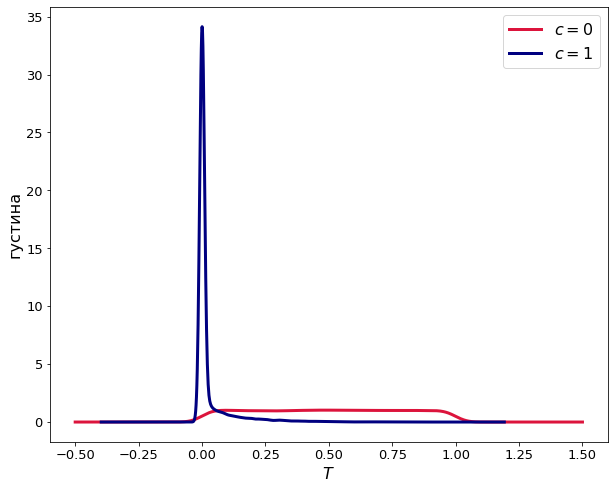

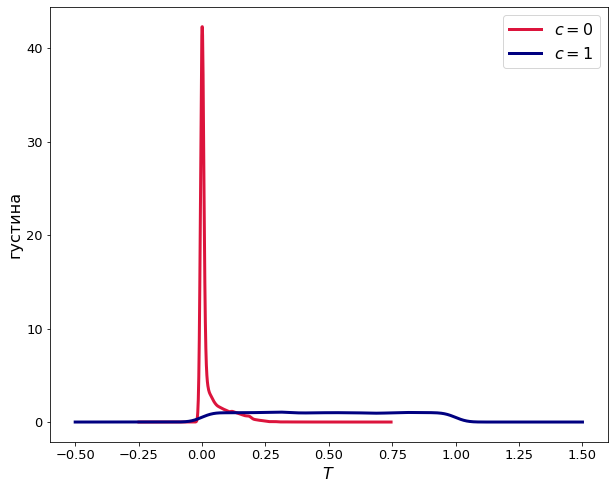

In [15]:
[fig_0, fig_1] = visualize_the_pvalue_density(fisher_tests, e2_separated,
                                              xlabel='$T$', ylabel='густина')

In [16]:
reports['p0_value_distribution_fig'] = fig_0
reports['p1_value_distribution_fig'] = fig_1

We see that the $p_1$-value is distributed approximately uniformly over $[0, 1]$ for the normal samples, whereas most of its distribution for the non-normal samples is located in the neighborhood of $0$, as it should be. The analogous conclusion holds for the $p_0$-value.

### Check the Boundedness Condition

First, define a function that checks the boundedness of the $p_c$ - value ($c=0,1$).

In [17]:
def check_boundedness(tests, separated_samples, colors=['crimson', 'navy'], alpha_granularity=100,
                     subsets=None, subset_size=50, subset_colors=['mistyrose', 'lavender']):
    alphas = np.linspace(0, 1, alpha_granularity)

    colors = {0: 'crimson', 1: 'navy'}
    
    figs = [None, None]
    for c in [0, 1]:
        line_label = r'$\alpha \mapsto P_{}\left(\hat{{p}}_{}(X) \leq \alpha \mid Y = {}\right)$'.format(c, c, c)
        figs[c] = plt.figure(figsize=(10, 8))
        
        plt.tick_params(axis='both', which='major', labelsize=16)
        plt.plot(alphas, alphas, linewidth=3, linestyle='--', color='black', 
                 zorder=2, label=r'$\alpha \mapsto \alpha$')
    
        p_values = [tests[c].p_value(x) for x in separated_samples[c]]
        #density = gaussian_kde(p_values)
    
        probabilities = []
        for alpha in alphas:
            prob = len([pval for pval in p_values if pval <= alpha]) / len(p_values)
            probabilities.append(prob)
            #probabilities.append(density.integrate_box_1d(0, alpha))
        
        #print(c, probabilities)
    
        plt.plot(alphas, probabilities, linewidth=3, color=colors[c], zorder=3, label=line_label)
    
        plt.legend(fontsize=16)

        if subsets is not None:
            for i in range(subsets):
                n = len(separated_samples[c])
                m = subset_size
                chosen_samples = [separated_samples[c][j] for j in np.random.choice(n, m, replace=False)]
                p_values = [tests[c].p_value(x) for x in chosen_samples]
            
                probabilities = []
                for alpha in alphas:
                    prob = len([pval for pval in p_values if pval <= alpha]) / len(p_values)
                    probabilities.append(prob)
                    #probabilities.append(density.integrate_box_1d(0, alpha))
                plt.plot(alphas, probabilities, linewidth=2, color=subset_colors[c], zorder=1)
    return figs

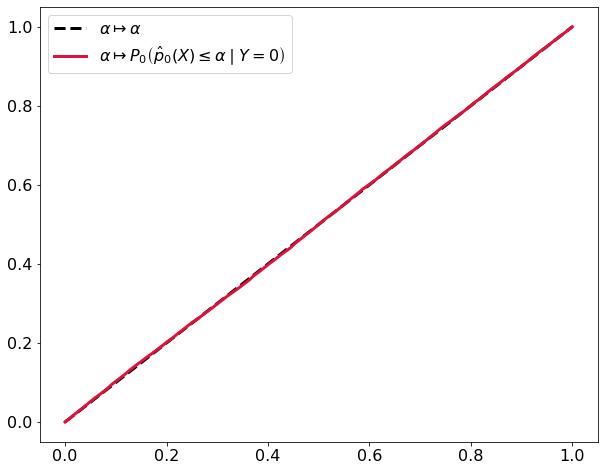

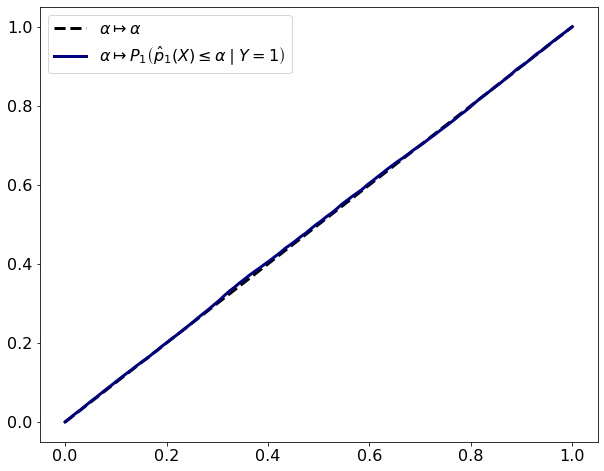

In [18]:
figs = check_boundedness(fisher_tests, e2_separated, subsets=None, subset_size=100)

In [19]:
reports['p0_value_uniform_fig'] = figs[0]
reports['p1_value_uniform_fig'] = figs[1]

Check boundedness for each sample size $n=10,20,\ldots, 100$.

In [20]:
#util.separate_by_size(datasets['E2']['samples'], datasets['E2']['labels'])
by_label_and_size = {}
for c in e2_separated:
    by_label_and_size[c] = util.separate_by_size(e2_separated[c])

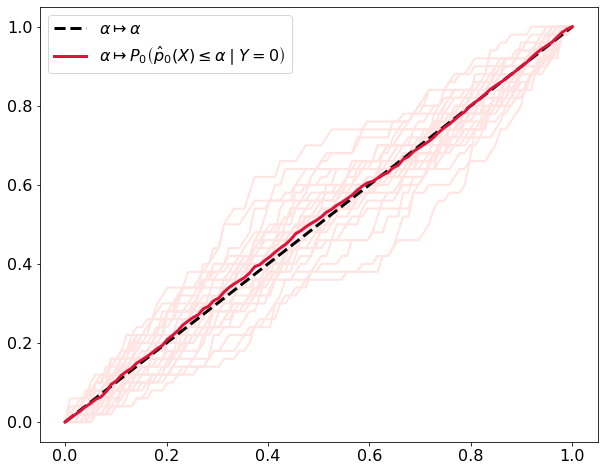

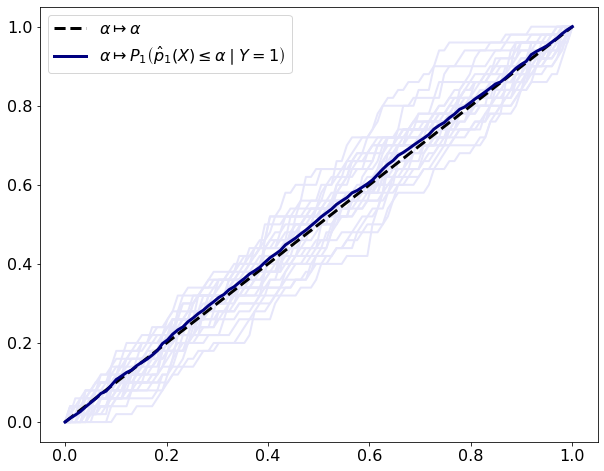

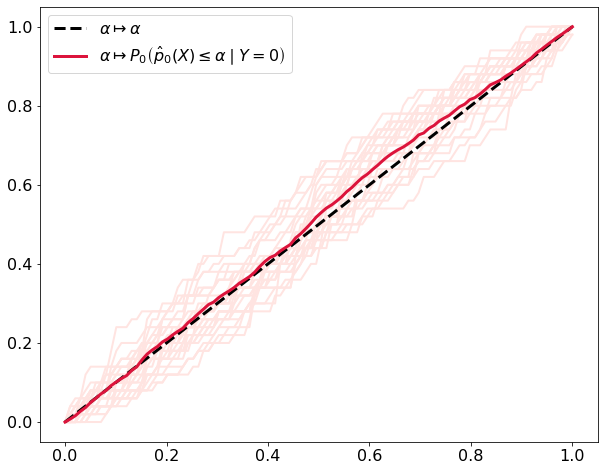

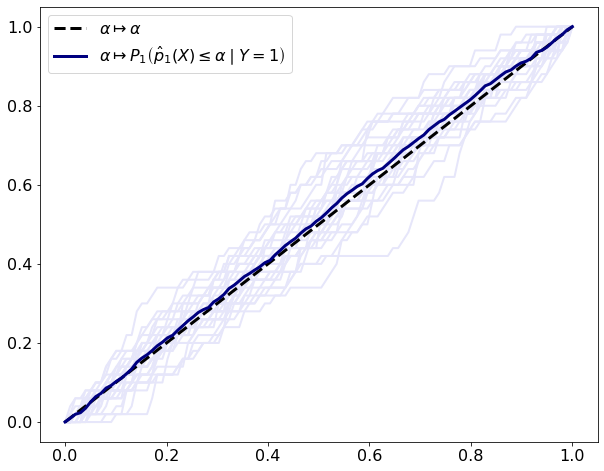

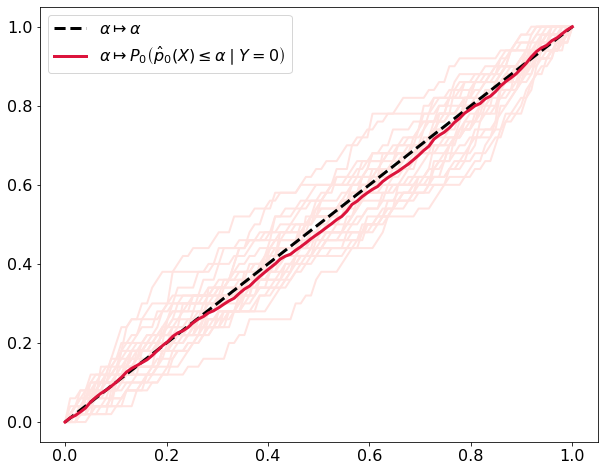

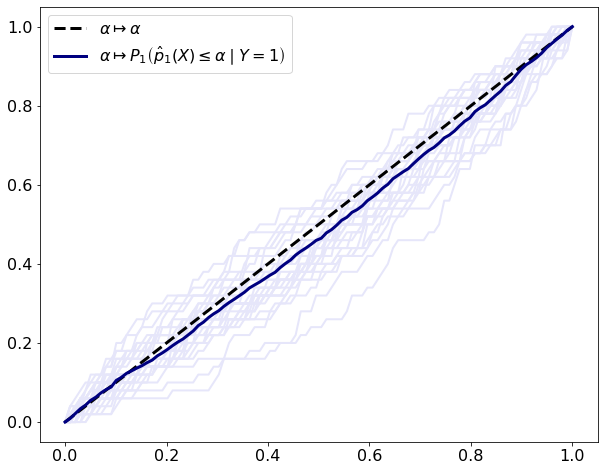

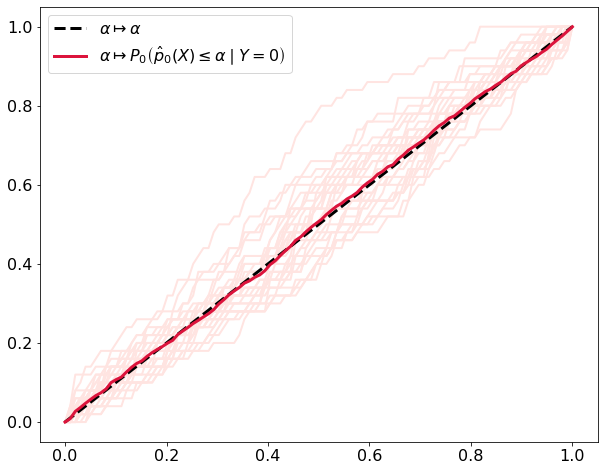

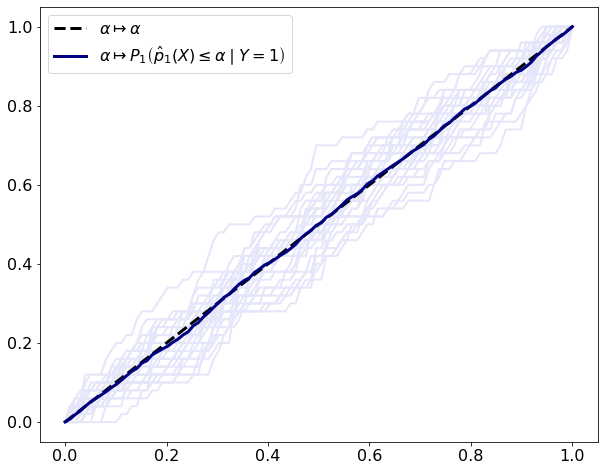

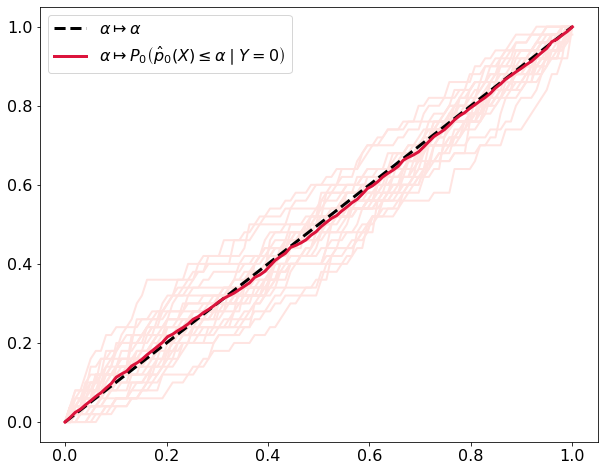

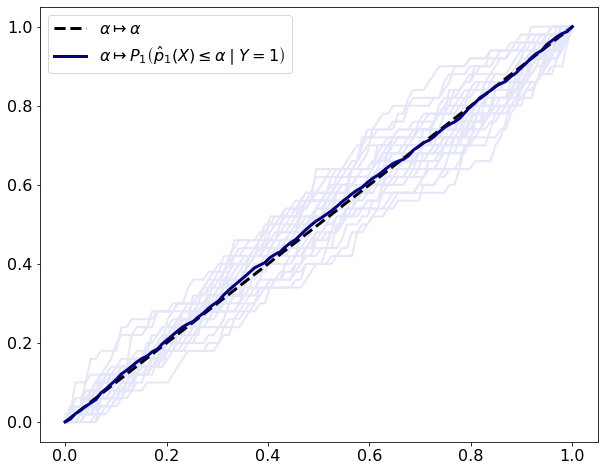

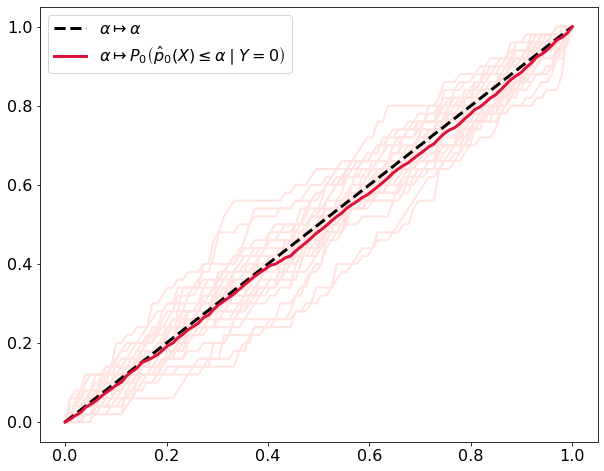

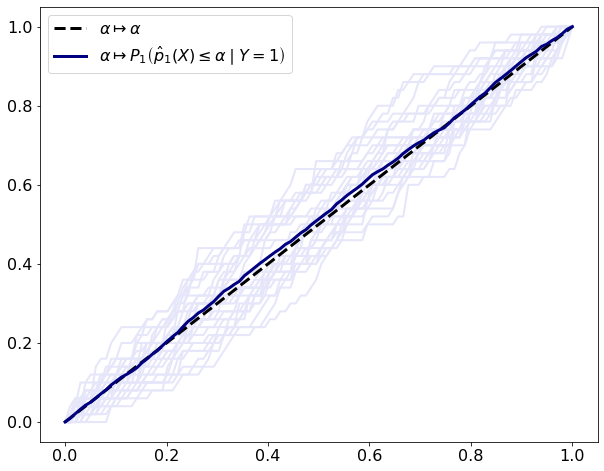

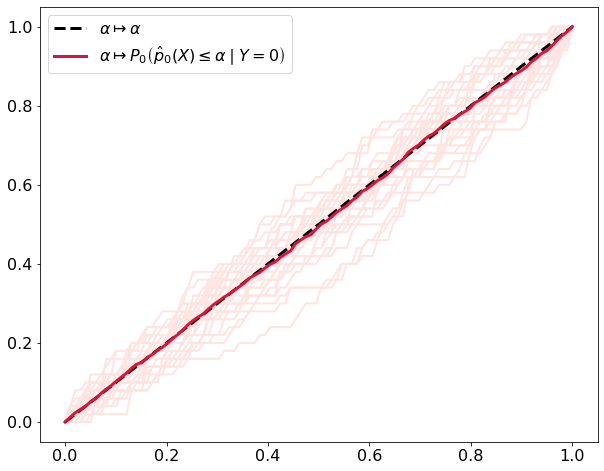

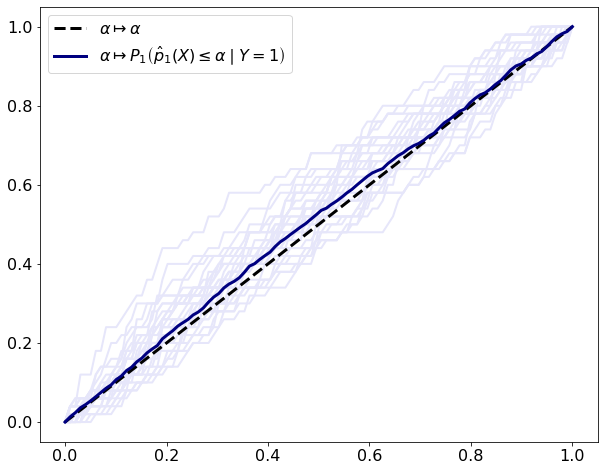

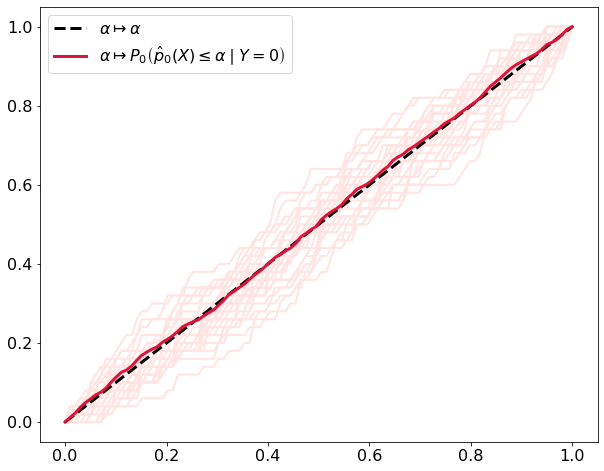

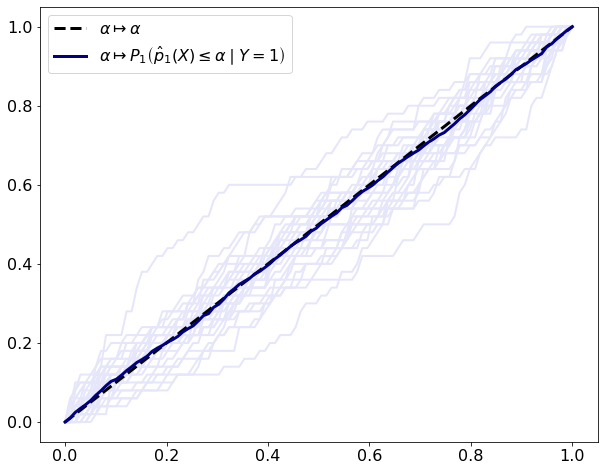

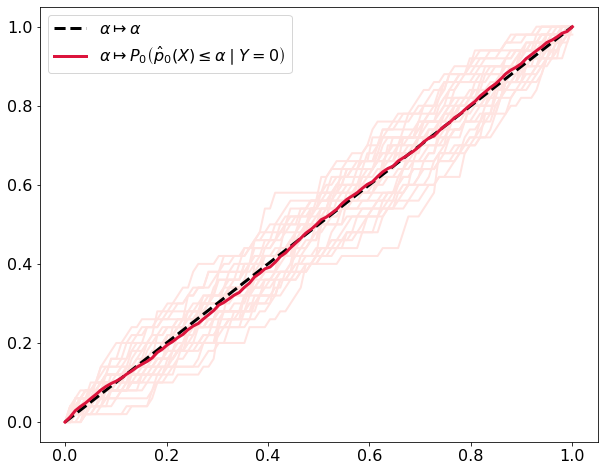

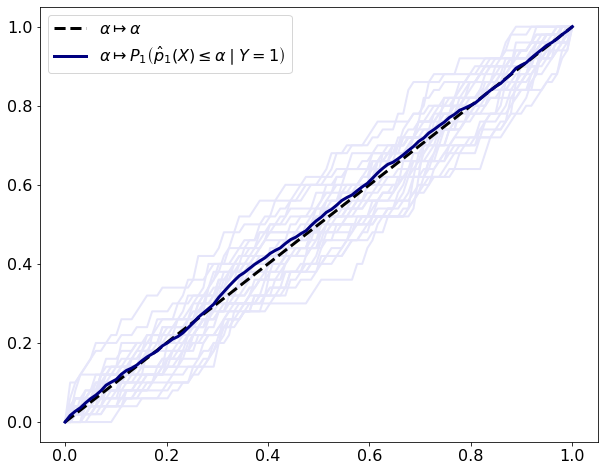

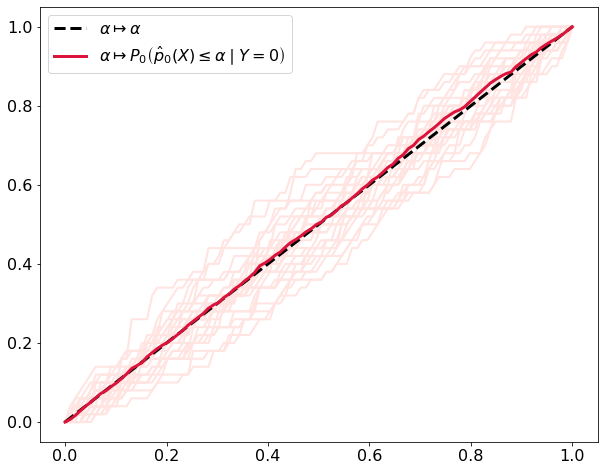

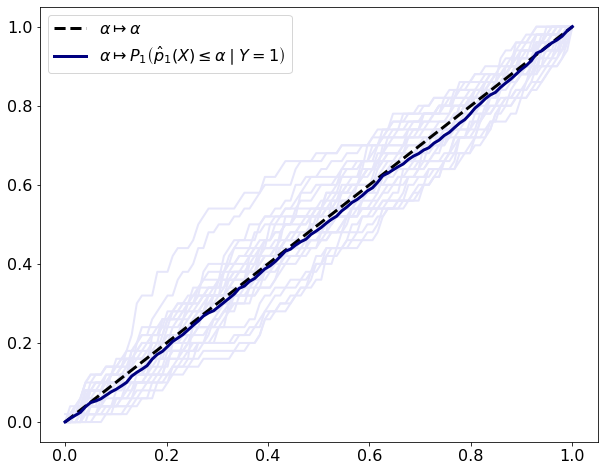

In [21]:
for n in range(10, 101, 10):
    size_n_e2 = {c : by_label_and_size[c][n] for c in [0, 1]}
    check_boundedness(fisher_tests, size_n_e2, subsets=30)

We see that the boundedness condition is fulfilled. This means that the $p_0$ and $p_1$ values can be used to control the overall error rates of the classifiers
$$\begin{cases}0,& p_1 \leq \alpha\\ 1,& p_1 > \alpha \end{cases}\qquad \alpha \in [0, 1]$$ and
$$\begin{cases}1,& p_0 \leq \beta\\ 0,& p_0 > \beta \end{cases}\qquad \beta \in [0, 1]$$
respectively.

### Check the Asymptotic Behavior

Check if the $p_c$-values gather around zero for the samples of the opposite class ($1-c$) as the sample size grows. Use the estimates of $P(p_c \leq \varepsilon)$ to quantify the degree to which the $p_c$-values are concentrated in the neighborhood of $0$ when calculated for the samples of the opposite class ($1-c$).

In [22]:
epsilon = 0.05

In [23]:
def check_asymptotic_behavior(tests, samples, labels, epsilon=0.05,
                              number_of_subsets=10, subset_relative_size=0.1,
                             colors=['crimson', 'navy']):
    probabilities = {}
    
    sample_groups = util.separate_by_label(samples, labels)
    for label in sample_groups:
        sample_groups[label] = util.separate_by_size(sample_groups[label])
    
    for c in [0, 1]:
        probabilities[c] = {}
        
        for size in sample_groups[c]:
            probabilities[c][size] = []
            group = sample_groups[1 - c][size]
            
            for i in range(number_of_subsets):
                if number_of_subsets == 1:
                    chosen_samples = group
                    n = len(group)
                else:
                    n = int(subset_relative_size * len(group))
                    chosen_samples = [group[j] for j in np.random.choice(len(group), n, replace=False)]
            
                p_values = [tests[c].p_value(x) for x in chosen_samples]
            
                number_of_lower = len([p_val for p_val in p_values if p_val <= epsilon])
                prob = number_of_lower / n
            
                #density = gaussian_kde(p_values)
                #prob = density.integrate_box_1d(0, epsilon)
                
                probabilities[c][size].append(prob)
    
    figs = [None, None]
    for c in probabilities:
        sample_sizes = sorted(list(probabilities[c].keys()))
        df = pd.DataFrame(probabilities[c])
        if number_of_subsets == 1:
            df = df[sample_sizes]
            figs[c] = df.T.plot(kind='line', figsize=(10, 8), label=None, linewidth=3)
        else:
            figs[c] = df.plot(kind='box', figsize=(10, 8))
        plt.ylabel('$P_{}(\hat{{p}}_{}(X) \leq {} \mid Y={})$'.format(c, c, epsilon, 1-c), fontsize=16)
        plt.xlabel('$n$', fontsize=16)
        plt.legend('',frameon=False)
            
    return figs

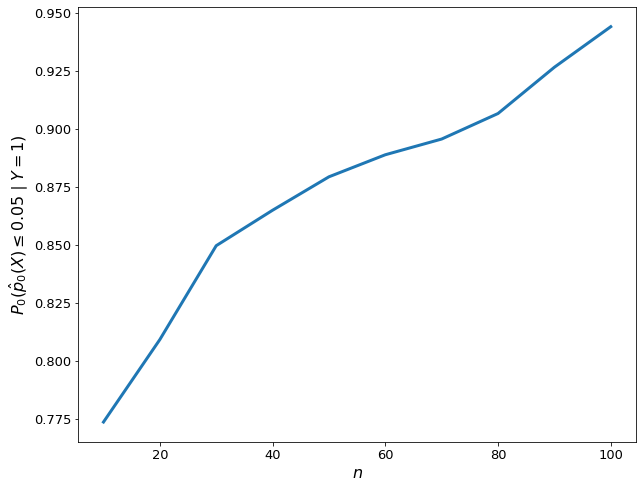

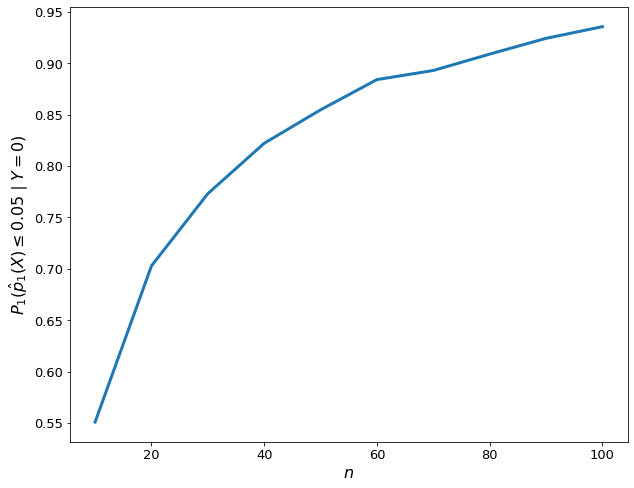

In [24]:
figs = check_asymptotic_behavior(fisher_tests, datasets['E2']['samples'], datasets['E2']['labels'],
                                number_of_subsets=1, epsilon=epsilon)

In [25]:
reports['p0_value_shrinks_for_1_fig'] = figs[0]
reports['p1_value_shrinks_for_0_fig'] = figs[1]

### The Fisher Classifier

A Fisherian classifier is of the form:
$$predict_{c, \alpha}(x)=\begin{cases}1-c,& p_c(T(x)) \leq \alpha\\ c,& p_c(T(x)) > \alpha \end{cases}\qquad \alpha \in [0, 1], c \in \{0, 1\}$$ 
Here, $T(x)$ is the value of the neural net's output layer when the whole pipe is fed the sample $x$ at the input.

For any $\alpha \in [0, 1]$, we can create two Fisher classifiers: one where $c=0$ and the other where $c=1$.

In [26]:
class StatisticalClassifier(object):
    def __init__(self):
        pass
    
    def predict(self, samples):
        pass

class OneTestClassifier(StatisticalClassifier):
    def __init__(self, test, class_label, alpha, opposite_label=None):
        super(OneTestClassifier, self).__init__()
        self.test = test
        self.class_label = class_label
        self.alpha = alpha
        
        if opposite_label is None:
            opposite_label = 1 - class_label
        self.opposite_label = opposite_label
    
    def calculate_statistic(self, samples):
        if not(all([type(s) == list for s in samples])):
            return self.test.calculate_statistic(samples)[0, 0]
            
        return np.array([self.test.calculate_statistic(sample) for sample in samples]).squeeze()
    
    def predict(self, samples):
        labels = [self.class_label if self.test.p_value(sample) > self.alpha \
                  else self.opposite_label for sample in samples]
        return labels

For example:

In [27]:
fisher_0 = OneTestClassifier(fisher_test_0, 0, 0.05)
fisher_1 = OneTestClassifier(fisher_test_1, 1, 0.05)

## Comparison with the DBNN Classifier and Standard Tests of Normality

### Create the Classifiers

In [28]:
classifiers = {}
import importlib
importlib.reload(util)

<module 'util' from '/home/milos/statisticka_klasifikacija/2020/util.py'>

In [29]:
class_codes = [1, 0]
alphas = [0.01, 0.05, 0.1]

for class_code in class_codes:
    test = fisher_tests[class_code]
    for alpha in alphas:
        classifier = OneTestClassifier(test, class_code, alpha)
        classifiers[('DBNN_{}'.format(class_code), alpha)] = classifier

Import standard statistical tests of normality (to be used as classifiers).

In [30]:
for code in ['SW', 'JB', 'LF', 'AD']:
    for alpha in alphas:
        classifier = util.get_standard_classifier(code, alpha)
        classifiers[(code, alpha)] = classifier

### The TNR Analysis on Set $\mathcal{C}$

In [31]:
n_range = range(10, 101, 10)
metrics = ['TNR']

results = {}
for group in ['C-G1', 'C-G2', 'C-G3', 'C-G4']:
    print(group)
    
    samples = datasets[group]['samples']
    labels = datasets[group]['labels']
    
    results[group] = {}
    for code in classifiers:
        if code[1] not in [0.1, 0.9]: #or 'DBNN' in code[0]:
            continue
        print('\t', code)
        
        classifier = classifiers[code]
        results_df = util.evaluate_pretty(samples, labels, classifier, metrics=metrics, n_range=n_range, index='n')
        results[group][code] = results_df

C-G1
	 ('DBNN_1', 0.1)
	 ('DBNN_0', 0.1)
	 ('SW', 0.1)
	 ('JB', 0.1)
	 ('LF', 0.1)
	 ('AD', 0.1)
C-G2
	 ('DBNN_1', 0.1)
	 ('DBNN_0', 0.1)
	 ('SW', 0.1)
	 ('JB', 0.1)
	 ('LF', 0.1)
	 ('AD', 0.1)
C-G3
	 ('DBNN_1', 0.1)
	 ('DBNN_0', 0.1)
	 ('SW', 0.1)
	 ('JB', 0.1)
	 ('LF', 0.1)
	 ('AD', 0.1)
C-G4
	 ('DBNN_1', 0.1)
	 ('DBNN_0', 0.1)
	 ('SW', 0.1)
	 ('JB', 0.1)
	 ('LF', 0.1)
	 ('AD', 0.1)


C-G1


,AD(0.1),DBNN_0(0.1),DBNN_1(0.1),JB(0.1),LF(0.1),SW(0.1)
n,,,,,,
10,0.334467,0.930907,0.818018,0.182282,0.305969,0.316668
20,0.487451,0.953705,0.877612,0.400460,0.421758,0.457554
30,0.554845,0.955004,0.938406,0.504050,0.484152,0.539246
40,0.613039,0.919808,0.922308,0.580542,0.544946,0.604340
50,0.652935,0.888311,0.939106,0.639336,0.583942,0.649535
60,0.677732,0.879912,0.923508,0.675632,0.609839,0.679332
70,0.709329,0.884912,0.933907,0.715128,0.642436,0.715828
80,0.739926,0.866413,0.928207,0.755124,0.678532,0.754625
90,0.757124,0.851815,0.921208,0.769523,0.700530,0.766123


\begin{table}
\centering
\caption{C-G1}
\label{fig:TNR_C-G1}
\begin{tabular}{lrrrrrr}
\toprule
{} &  AD(0.1) &  DBNN_0(0.1) &  DBNN_1(0.1) &  JB(0.1) &  LF(0.1) &  SW(0.1) \\
n       &          &              &              &          &          &          \\
\midrule
10      &  $0.334$ &      $0.931$ &      $0.818$ &  $0.182$ &  $0.306$ &  $0.317$ \\
20      &  $0.487$ &      $0.954$ &      $0.878$ &  $0.400$ &  $0.422$ &  $0.458$ \\
30      &  $0.555$ &      $0.955$ &      $0.938$ &  $0.504$ &  $0.484$ &  $0.539$ \\
40      &  $0.613$ &      $0.920$ &      $0.922$ &  $0.581$ &  $0.545$ &  $0.604$ \\
50      &  $0.653$ &      $0.888$ &      $0.939$ &  $0.639$ &  $0.584$ &  $0.650$ \\
60      &  $0.678$ &      $0.880$ &      $0.924$ &  $0.676$ &  $0.610$ &  $0.679$ \\
70      &  $0.709$ &      $0.885$ &      $0.934$ &  $0.715$ &  $0.642$ &  $0.716$ \\
80      &  $0.740$ &      $0.866$ &      $0.928$ &  $0.755$ &  $0.679$ &  $0.755$ \\
90      &  $0.757$ &      $0.852$ &      $0.921$ & 

,AD(0.1),DBNN_0(0.1),DBNN_1(0.1),JB(0.1),LF(0.1),SW(0.1)
n,,,,,,
10,0.235776,0.995600,0.934707,0.079592,0.190281,0.240576
20,0.396860,0.977602,0.880612,0.241576,0.281872,0.407559
30,0.528947,0.985701,0.956604,0.399260,0.392461,0.567443
40,0.621838,0.973103,0.974603,0.528247,0.479752,0.680832
50,0.712129,0.961104,0.991201,0.640936,0.566443,0.775422
60,0.776622,0.936706,0.978302,0.729627,0.630737,0.839616
70,0.831317,0.977702,0.996000,0.806419,0.686031,0.891011
80,0.870313,0.952105,0.994501,0.857314,0.749525,0.922908
90,0.908109,0.929607,0.993201,0.899710,0.795620,0.949405


\begin{table}
\centering
\caption{C-G2}
\label{fig:TNR_C-G2}
\begin{tabular}{lrrrrrr}
\toprule
{} &  AD(0.1) &  DBNN_0(0.1) &  DBNN_1(0.1) &  JB(0.1) &  LF(0.1) &  SW(0.1) \\
n       &          &              &              &          &          &          \\
\midrule
10      &  $0.236$ &      $0.996$ &      $0.935$ &  $0.080$ &  $0.190$ &  $0.241$ \\
20      &  $0.397$ &      $0.978$ &      $0.881$ &  $0.242$ &  $0.282$ &  $0.408$ \\
30      &  $0.529$ &      $0.986$ &      $0.957$ &  $0.399$ &  $0.392$ &  $0.567$ \\
40      &  $0.622$ &      $0.973$ &      $0.975$ &  $0.528$ &  $0.480$ &  $0.681$ \\
50      &  $0.712$ &      $0.961$ &      $0.991$ &  $0.641$ &  $0.566$ &  $0.775$ \\
60      &  $0.777$ &      $0.937$ &      $0.978$ &  $0.730$ &  $0.631$ &  $0.840$ \\
70      &  $0.831$ &      $0.978$ &      $0.996$ &  $0.806$ &  $0.686$ &  $0.891$ \\
80      &  $0.870$ &      $0.952$ &      $0.995$ &  $0.857$ &  $0.750$ &  $0.923$ \\
90      &  $0.908$ &      $0.930$ &      $0.993$ & 

,AD(0.1),DBNN_0(0.1),DBNN_1(0.1),JB(0.1),LF(0.1),SW(0.1)
n,,,,,,
10,0.595340,0.959604,0.951305,0.286771,0.503550,0.610839
20,0.790821,0.965903,0.951805,0.612739,0.702730,0.806519
30,0.854015,0.961404,0.960304,0.756024,0.781922,0.874513
40,0.890911,0.956904,0.957304,0.827417,0.829117,0.911509
50,0.915808,0.951605,0.959304,0.874213,0.862914,0.939006
60,0.928007,0.938606,0.955204,0.898410,0.887911,0.951005
70,0.940706,0.953705,0.957804,0.921408,0.901610,0.963804
80,0.951505,0.943506,0.959904,0.937606,0.921908,0.972603
90,0.960404,0.926607,0.956904,0.946905,0.931107,0.980902


\begin{table}
\centering
\caption{C-G3}
\label{fig:TNR_C-G3}
\begin{tabular}{lrrrrrr}
\toprule
{} &  AD(0.1) &  DBNN_0(0.1) &  DBNN_1(0.1) &  JB(0.1) &  LF(0.1) &  SW(0.1) \\
n       &          &              &              &          &          &          \\
\midrule
10      &  $0.595$ &      $0.960$ &      $0.951$ &  $0.287$ &  $0.504$ &  $0.611$ \\
20      &  $0.791$ &      $0.966$ &      $0.952$ &  $0.613$ &  $0.703$ &  $0.807$ \\
30      &  $0.854$ &      $0.961$ &      $0.960$ &  $0.756$ &  $0.782$ &  $0.875$ \\
40      &  $0.891$ &      $0.957$ &      $0.957$ &  $0.827$ &  $0.829$ &  $0.912$ \\
50      &  $0.916$ &      $0.952$ &      $0.959$ &  $0.874$ &  $0.863$ &  $0.939$ \\
60      &  $0.928$ &      $0.939$ &      $0.955$ &  $0.898$ &  $0.888$ &  $0.951$ \\
70      &  $0.941$ &      $0.954$ &      $0.958$ &  $0.921$ &  $0.902$ &  $0.964$ \\
80      &  $0.952$ &      $0.944$ &      $0.960$ &  $0.938$ &  $0.922$ &  $0.973$ \\
90      &  $0.960$ &      $0.927$ &      $0.957$ & 

,AD(0.1),DBNN_0(0.1),DBNN_1(0.1),JB(0.1),LF(0.1),SW(0.1)
n,,,,,,
10,0.206779,1.000000,0.991301,0.010599,0.151285,0.218778
20,0.396860,0.999900,0.987401,0.020798,0.248575,0.423458
30,0.517748,1.000000,1.000000,0.030797,0.337966,0.569243
40,0.611139,0.992701,0.993701,0.071493,0.425657,0.686531
50,0.685331,0.869413,1.000000,0.209079,0.499650,0.759224
60,0.743726,0.562044,0.935706,0.357964,0.564444,0.820918
70,0.784322,0.950605,1.000000,0.480052,0.611539,0.859014
80,0.817518,0.520248,0.999000,0.587941,0.660634,0.888011
90,0.842516,0.450655,0.989101,0.681432,0.691831,0.906309


\begin{table}
\centering
\caption{C-G4}
\label{fig:TNR_C-G4}
\begin{tabular}{lrrrrrr}
\toprule
{} &  AD(0.1) &  DBNN_0(0.1) &  DBNN_1(0.1) &  JB(0.1) &  LF(0.1) &  SW(0.1) \\
n       &          &              &              &          &          &          \\
\midrule
10      &  $0.207$ &      $1.000$ &      $0.991$ &  $0.011$ &  $0.151$ &  $0.219$ \\
20      &  $0.397$ &      $1.000$ &      $0.987$ &  $0.021$ &  $0.249$ &  $0.423$ \\
30      &  $0.518$ &      $1.000$ &      $1.000$ &  $0.031$ &  $0.338$ &  $0.569$ \\
40      &  $0.611$ &      $0.993$ &      $0.994$ &  $0.071$ &  $0.426$ &  $0.687$ \\
50      &  $0.685$ &      $0.869$ &      $1.000$ &  $0.209$ &  $0.500$ &  $0.759$ \\
60      &  $0.744$ &      $0.562$ &      $0.936$ &  $0.358$ &  $0.564$ &  $0.821$ \\
70      &  $0.784$ &      $0.951$ &      $1.000$ &  $0.480$ &  $0.612$ &  $0.859$ \\
80      &  $0.818$ &      $0.520$ &      $0.999$ &  $0.588$ &  $0.661$ &  $0.888$ \\
90      &  $0.843$ &      $0.451$ &      $0.989$ & 

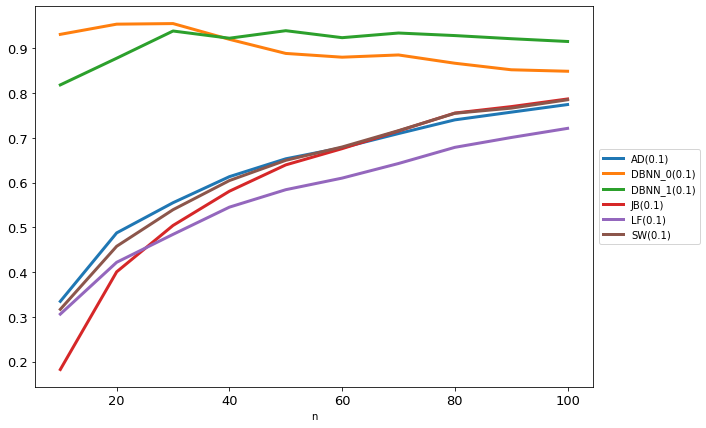

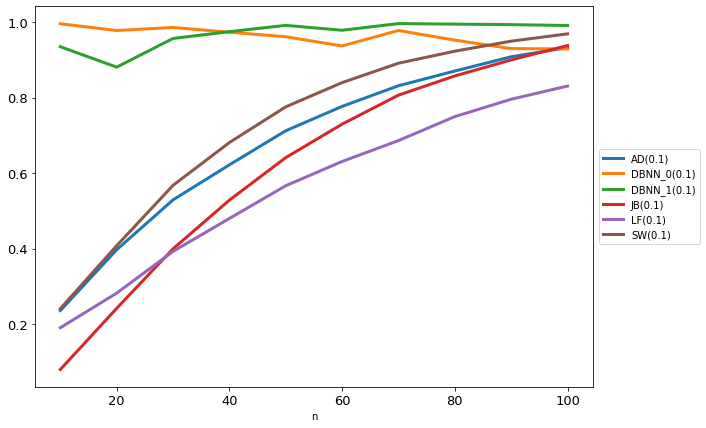

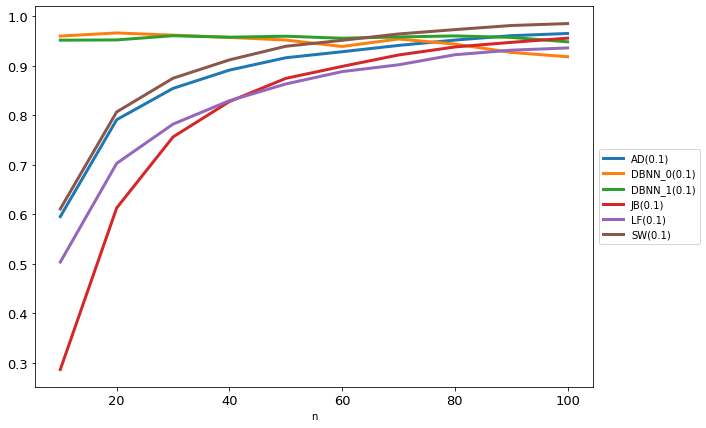

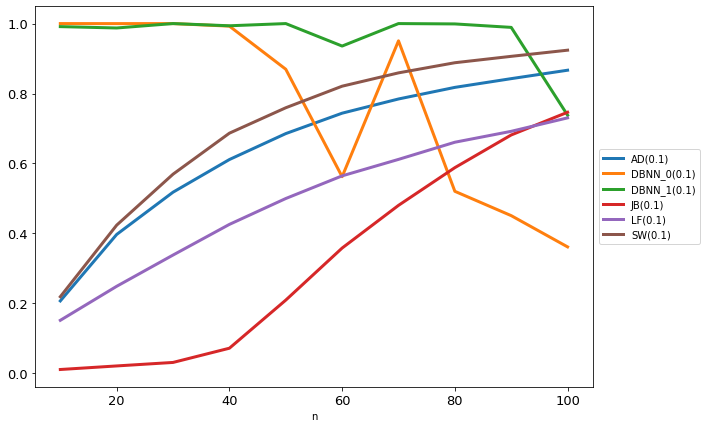

In [32]:
for group in results:
    print(group)
    dfs = results[group]
    results_dict = {'{}({})'.format(*code): dfs[code]['TNR'] for code in dfs}
    results_df = pd.concat(results_dict, axis=1)
    results_df = results_df[sorted(results_df.columns)]
    #results_df['DBNN'] = dbnn_storage['results']['evaluation'][group]['TNR']
    #results_df = results_df[['DBNN'] + [col for col in results_df.columns if col != 'DBNN']]
    
    display(results_df)
    latex = util.get_latex_table(results_df, index=True, caption=group,
                                 label='fig:TNR_' + group)
    print(latex)
    
    #dbnn_storage['results']['comparison'][group] = results_df
    df = results_df
    fig = df[df.index != 'overall'].plot(kind='line', #style=['o-', 'v--', '^--', 's--', 'D--'],
                                         #color=['navy', 'darkred', 'red', 'orangered', 'orange'],
                                         linewidth=3,
                                         figsize=(10,7), use_index=True)
    reports['{}_fig'.format(group)] = fig
    fig.legend(loc='center right', bbox_to_anchor=(1.2, 0.5))
    #latex = util.get_latex_table(df, float_format=float_format, index=True, caption='C', label='c')
    #dbnn_storage['reports']['comparison'][group] = {'fig' : fig, 'latex': latex}
    #print(latex)

### The Overall Performance Analysis on Set $\mathcal{D}$

In [33]:
import importlib
importlib.reload(util)
samples = datasets['D']['samples']
labels = datasets['D']['labels']

In [35]:
results = {}

metrics = ['A', 'TPR', 'PPV', 'TNR', 'NPV', 'F1']

for (code, alpha) in classifiers:
    print(code, alpha)
    classifier = classifiers[(code, alpha)]
    print('\tStart:', dt.datetime.now())
    results_df = util.evaluate_pretty(samples, labels, classifier, metrics=metrics)
    print('\tEnd:', str(dt.datetime.now()))
    results[(code, alpha)] = results_df

print('DBNN')
results[('DBNN', '')] = util.evaluate_pretty(samples, labels, dbnn, metrics=metrics)

DBNN_1 0.01
	Start: 2020-09-24 07:22:16.770795
	End: 2020-09-24 07:23:36.375549
DBNN_1 0.05
	Start: 2020-09-24 07:23:36.375661
	End: 2020-09-24 07:25:01.704208
DBNN_1 0.1
	Start: 2020-09-24 07:25:01.704347
	End: 2020-09-24 07:26:25.190313
DBNN_0 0.01
	Start: 2020-09-24 07:26:25.190433
	End: 2020-09-24 07:27:57.943654
DBNN_0 0.05
	Start: 2020-09-24 07:27:57.943783
	End: 2020-09-24 07:29:32.080272
DBNN_0 0.1
	Start: 2020-09-24 07:29:32.080655
	End: 2020-09-24 07:31:03.407628
SW 0.01
	Start: 2020-09-24 07:31:03.407749
	End: 2020-09-24 07:31:03.838699
SW 0.05
	Start: 2020-09-24 07:31:03.839185
	End: 2020-09-24 07:31:04.277253
SW 0.1
	Start: 2020-09-24 07:31:04.277373
	End: 2020-09-24 07:31:04.708626
JB 0.01
	Start: 2020-09-24 07:31:04.708745
	End: 2020-09-24 07:31:09.595083
JB 0.05
	Start: 2020-09-24 07:31:09.595204
	End: 2020-09-24 07:31:14.471609
JB 0.1
	Start: 2020-09-24 07:31:14.471730
	End: 2020-09-24 07:31:19.317424
LF 0.01
	Start: 2020-09-24 07:31:19.317545
	End: 2020-09-24 07:31:30

In [36]:
df_report = pd.concat(results)
#df_report.index=pd.MultiIndex.from_tuples([(x[0], x[1]) for x in df_report.index])


keys = sorted([x for x in results.keys() if x[0] != 'DBNN']) + [('DBNN', '')]
df_report = pd.concat({x : results[x] for x in keys})

display(df_report)

print(util.get_latex_table(df_report, index=True, caption='C', label='x'))

A       TPR       PPV       TNR       NPV        F1
AD     0.01 0  0.801762  0.991341  0.718802  0.612184  0.986053  0.833355
       0.05 0  0.826820  0.951264  0.761689  0.702375  0.935115  0.845986
       0.1  0  0.826973  0.897701  0.786453  0.756245  0.880846  0.838403
DBNN_0 0.01 0  0.900268  0.809195  0.989413  0.991341  0.838595  0.890275
       0.05 0  0.915211  0.881839  0.944905  0.948582  0.889232  0.912283
       0.1  0  0.910690  0.922069  0.901551  0.899310  0.920254  0.911695
DBNN_1 0.01 0  0.839885  0.991111  0.760958  0.688659  0.987257  0.860918
       0.05 0  0.890766  0.952720  0.847685  0.828812  0.946033  0.897139
       0.1  0  0.905479  0.904291  0.906444  0.906667  0.904518  0.905367
JB     0.01 0  0.810651  0.984215  0.730603  0.637088  0.975822  0.838655
       0.05 0  0.829502  0.967663  0.758165  0.691341  0.955316  0.850199
       0.1  0  0.835709  0.948352  0.773984  0.723065  0.933333  0.852342
LF     0.01 0  0.758659  0.990038  0.676830  0.527280  0.981458  0.804008
       0.05 0  0.791341  0.952031  0.720482  0.630651  0.929313  0.820228
       0.1  0  0.796897  0.900536  0.745922  0.693257  0.874529  0.815969
SW     0.01 0  0.820000  0.989425  0.739011  0.650575  0.984006  0.846078
       0.05 0  0.839464  0.953027  0.776633  0.725900  0.939223  0.855835
       0.1  0  0.835441  0.903218  0.795398  0.767663  0.888042  0.845886
DBNN        0  0.912337  0.878161  0.942589  0.946513  0.885956  0.909235

\begin{table}
\centering
\caption{C}
\label{x}
\begin{tabular}{lllrrrrrr}
\toprule
     &     &   &       A &     TPR &     PPV &     TNR &     NPV &      F1 \\
\midrule
AD & 0.01 & 0 & $0.802$ & $0.991$ & $0.719$ & $0.612$ & $0.986$ & $0.833$ \\
     & 0.05 & 0 & $0.827$ & $0.951$ & $0.762$ & $0.702$ & $0.935$ & $0.846$ \\
     & 0.1 & 0 & $0.827$ & $0.898$ & $0.786$ & $0.756$ & $0.881$ & $0.838$ \\
DBNN_0 & 0.01 & 0 & $0.900$ & $0.809$ & $0.989$ & $0.991$ & $0.839$ & $0.890$ \\
     & 0.05 & 0 & $0.915$ & $0.882$ & $0.945$ & $0.949$ & $0.889$ & $0.912$ \\
     & 0.1 & 0 & $0.911$ & $0.922$ & $0.902$ & $0.899$ & $0.920$ & $0.912$ \\
DBNN_1 & 0.01 & 0 & $0.840$ & $0.991$ & $0.761$ & $0.689$ & $0.987$ & $0.861$ \\
     & 0.05 & 0 & $0.891$ & $0.953$ & $0.848$ & $0.829$ & $0.946$ & $0.897$ \\
     & 0.1 & 0 & $0.905$ & $0.904$ & $0.906$ & $0.907$ & $0.905$ & $0.905$ \\
JB & 0.01 & 0 & $0.811$ & $0.984$ & $0.731$ & $0.637$ & $0.976$ & $0.839$ \\
     & 0.05 & 0 & $0.830$ & $0.968$ & $0.75

In [37]:
dfs = {}
for code in classifiers:
    print(code)
    classifier = classifiers[code]
    df = util.evaluate_pretty(samples, labels, classifier, metrics=metrics, n_range=range(10, 101, 10))
    dfs[code] = df
    display(df)

('DBNN_1', 0.01)


,n,A,TPR,PPV,TNR,NPV,F1
0,10,0.668582,0.991571,0.602421,0.345594,0.976190,0.749493
1,20,0.762452,0.991571,0.679979,0.533333,0.984441,0.806733
2,30,0.801916,0.994636,0.717920,0.609195,0.991272,0.833922
3,40,0.832950,0.990038,0.753353,0.675862,0.985475,0.855629
4,50,0.861686,0.991571,0.787105,0.731801,0.988613,0.877586
5,60,0.871648,0.990038,0.800496,0.753257,0.986948,0.885235
6,70,0.891188,0.994636,0.824127,0.787739,0.993237,0.901389
7,80,0.888889,0.989272,0.823867,0.788506,0.986577,0.899025
8,90,0.913027,0.989272,0.858378,0.836782,0.987342,0.919188
9,100,0.906513,0.988506,0.849243,0.824521,0.986251,0.913598


('DBNN_1', 0.05)


,n,A,TPR,PPV,TNR,NPV,F1
0,10,0.754789,0.957088,0.681397,0.552490,0.927928,0.796048
1,20,0.828736,0.944828,0.766791,0.712644,0.928144,0.846550
2,30,0.866284,0.957854,0.809585,0.774713,0.948405,0.877501
3,40,0.888506,0.939464,0.852573,0.837548,0.932594,0.893912
4,50,0.907663,0.954023,0.873072,0.861303,0.949324,0.911754
5,60,0.921456,0.958621,0.892297,0.884291,0.955298,0.924270
6,70,0.918008,0.953257,0.890480,0.882759,0.949711,0.920799
7,80,0.935632,0.952490,0.921423,0.918774,0.950833,0.936699
8,90,0.936015,0.950192,0.923994,0.921839,0.948738,0.936910
9,100,0.950575,0.959387,0.942771,0.941762,0.958658,0.951006


('DBNN_1', 0.1)


,n,A,TPR,PPV,TNR,NPV,F1
0,10,0.814176,0.900383,0.767974,0.727969,0.879630,0.828924
1,20,0.856705,0.891188,0.833692,0.822222,0.883128,0.861481
2,30,0.892720,0.914176,0.876561,0.871264,0.910328,0.894974
3,40,0.904981,0.901916,0.907479,0.908046,0.902513,0.904689
4,50,0.924904,0.907280,0.940429,0.942529,0.910437,0.923557
5,60,0.927203,0.905747,0.946357,0.948659,0.909625,0.925607
6,70,0.926054,0.902682,0.946945,0.949425,0.907028,0.924284
7,80,0.936015,0.904981,0.964869,0.967050,0.910534,0.933966
8,90,0.926820,0.894253,0.956557,0.959387,0.900719,0.924356
9,100,0.945211,0.920307,0.968548,0.970115,0.924088,0.943811


('DBNN_0', 0.01)


,n,A,TPR,PPV,TNR,NPV,F1
0,10,0.840230,0.687356,0.990066,0.993103,0.760563,0.811398
1,20,0.870115,0.747126,0.990854,0.993103,0.797048,0.851900
2,30,0.899234,0.812261,0.983302,0.986207,0.840078,0.889635
3,40,0.895402,0.796169,0.993308,0.994636,0.829923,0.883879
4,50,0.908046,0.822989,0.991690,0.993103,0.848723,0.899497
5,60,0.906513,0.820690,0.990749,0.992337,0.846959,0.897737
6,70,0.913027,0.836015,0.988225,0.990038,0.857902,0.905770
7,80,0.923372,0.852874,0.992864,0.993870,0.871054,0.917560
8,90,0.924904,0.865900,0.981755,0.983908,0.880055,0.920195
9,100,0.921839,0.850575,0.991957,0.993103,0.869215,0.915842


('DBNN_0', 0.05)


,n,A,TPR,PPV,TNR,NPV,F1
0,10,0.859387,0.773946,0.933457,0.944828,0.806937,0.846251
1,20,0.886590,0.819923,0.946065,0.953257,0.841109,0.878489
2,30,0.904215,0.862069,0.941423,0.946360,0.872792,0.900000
3,40,0.904981,0.866667,0.938589,0.943295,0.876157,0.901195
4,50,0.922605,0.895019,0.947283,0.950192,0.900508,0.920410
5,60,0.925287,0.895019,0.952692,0.955556,0.901012,0.922955
6,70,0.926054,0.902682,0.946945,0.949425,0.907028,0.924284
7,80,0.938697,0.922605,0.953286,0.954789,0.925019,0.937695
8,90,0.934483,0.934866,0.934150,0.934100,0.934816,0.934508
9,100,0.949808,0.945594,0.953632,0.954023,0.946049,0.949596


('DBNN_0', 0.1)


,n,A,TPR,PPV,TNR,NPV,F1
0,10,0.858238,0.821456,0.886683,0.895019,0.833690,0.852824
1,20,0.880460,0.853640,0.902024,0.907280,0.861091,0.877165
2,30,0.896169,0.888889,0.902022,0.903448,0.890483,0.895407
3,40,0.903831,0.901916,0.905385,0.905747,0.902290,0.903647
4,50,0.919157,0.939464,0.902798,0.898851,0.936901,0.920766
5,60,0.924904,0.945594,0.908021,0.904215,0.943245,0.926426
6,70,0.920307,0.951724,0.895458,0.888889,0.948487,0.922734
7,80,0.929502,0.967816,0.898932,0.891188,0.965145,0.932103
8,90,0.932950,0.974713,0.899576,0.891188,0.972408,0.935638
9,100,0.941379,0.975479,0.913199,0.907280,0.973684,0.943312


('SW', 0.01)


,n,A,TPR,PPV,TNR,NPV,F1
0,10,0.650192,0.992337,0.589172,0.308046,0.975728,0.739366
1,20,0.732950,0.991571,0.653535,0.474330,0.982540,0.787823
2,30,0.776628,0.990038,0.693878,0.563218,0.982620,0.815914
3,40,0.811494,0.992337,0.728756,0.630651,0.987995,0.840363
4,50,0.835249,0.985441,0.757808,0.685057,0.979189,0.856762
5,60,0.855939,0.988506,0.781345,0.723372,0.984359,0.872801
6,70,0.863985,0.988506,0.791411,0.739464,0.984694,0.879046
7,80,0.876245,0.985441,0.808805,0.767050,0.981373,0.888428
8,90,0.897701,0.993870,0.833548,0.801533,0.992410,0.906676
9,100,0.899617,0.986207,0.840627,0.813027,0.983318,0.907616


('SW', 0.05)


,n,A,TPR,PPV,TNR,NPV,F1
0,10,0.678544,0.948659,0.615920,0.408429,0.888333,0.746908
1,20,0.762835,0.960153,0.688462,0.565517,0.934177,0.801920
2,30,0.806130,0.959387,0.734311,0.652874,0.941436,0.831894
3,40,0.838314,0.960920,0.771692,0.715709,0.948223,0.855973
4,50,0.855172,0.950958,0.798071,0.759387,0.939336,0.867832
5,60,0.862835,0.947893,0.810085,0.777778,0.937211,0.873588
6,70,0.881609,0.948659,0.836486,0.814559,0.940708,0.889048
7,80,0.894253,0.953257,0.852639,0.835249,0.947003,0.900145
8,90,0.906130,0.957854,0.868056,0.854406,0.952991,0.910747
9,100,0.908812,0.942529,0.882986,0.875096,0.938373,0.911787


('SW', 0.1)


,n,A,TPR,PPV,TNR,NPV,F1
0,10,0.693103,0.898851,0.636808,0.487356,0.828125,0.745472
1,20,0.765517,0.908046,0.706619,0.622989,0.871383,0.794769
2,30,0.801533,0.906513,0.749208,0.696552,0.881668,0.820388
3,40,0.829885,0.909579,0.784534,0.750192,0.892434,0.842441
4,50,0.848659,0.899617,0.816412,0.797701,0.888225,0.855997
5,60,0.859770,0.903448,0.830867,0.816092,0.894207,0.865639
6,70,0.878161,0.899617,0.862601,0.856705,0.895116,0.880720
7,80,0.886590,0.911111,0.868517,0.862069,0.906527,0.889304
8,90,0.893103,0.904215,0.884558,0.881992,0.902038,0.894278
9,100,0.898084,0.891188,0.903652,0.904981,0.892668,0.897377


('JB', 0.01)


,n,A,TPR,PPV,TNR,NPV,F1
0,10,0.580460,0.997701,0.543860,0.163218,0.986111,0.703974
1,20,0.702682,0.993870,0.628087,0.411494,0.985321,0.769733
2,30,0.762452,0.990805,0.680168,0.534100,0.983075,0.806613
3,40,0.803448,0.982375,0.723476,0.624521,0.972554,0.833279
4,50,0.832950,0.979310,0.757558,0.686590,0.970748,0.854278
5,60,0.852874,0.978544,0.781996,0.727203,0.971341,0.869299
6,70,0.870881,0.979310,0.804786,0.762452,0.973581,0.883512
7,80,0.883142,0.977778,0.822165,0.788506,0.972590,0.893245
8,90,0.903065,0.984674,0.846509,0.821456,0.981685,0.910379
9,100,0.914559,0.977778,0.868027,0.851341,0.974561,0.919640


('JB', 0.05)


,n,A,TPR,PPV,TNR,NPV,F1
0,10,0.602682,0.992337,0.557709,0.213027,0.965278,0.714089
1,20,0.734100,0.985441,0.655788,0.482759,0.970724,0.787508
2,30,0.788123,0.979310,0.708426,0.596935,0.966501,0.822129
3,40,0.828352,0.968582,0.756433,0.688123,0.956337,0.849462
4,50,0.850958,0.957854,0.789141,0.744061,0.946394,0.865351
5,60,0.868199,0.957854,0.812216,0.778544,0.948646,0.879044
6,70,0.884291,0.955556,0.836351,0.813027,0.948168,0.891989
7,80,0.898467,0.960153,0.854707,0.836782,0.954545,0.904367
8,90,0.915326,0.965517,0.877437,0.865134,0.961670,0.919372
9,100,0.924521,0.954023,0.900868,0.895019,0.951140,0.926684


('JB', 0.1)


,n,A,TPR,PPV,TNR,NPV,F1
0,10,0.622605,0.986207,0.570985,0.259004,0.949438,0.723237
1,20,0.745977,0.976245,0.668416,0.515709,0.955966,0.793522
2,30,0.800000,0.958621,0.727749,0.641379,0.939394,0.827381
3,40,0.840996,0.956322,0.777086,0.725670,0.943227,0.857437
4,50,0.858621,0.937165,0.809934,0.780077,0.925455,0.868917
5,60,0.875862,0.940230,0.832994,0.811494,0.931398,0.883369
6,70,0.888123,0.933333,0.855938,0.842912,0.926706,0.892962
7,80,0.899234,0.934866,0.872675,0.863602,0.929868,0.902701
8,90,0.909195,0.936398,0.888081,0.881992,0.932739,0.911600
9,100,0.916475,0.924138,0.910189,0.908812,0.922957,0.917110


('LF', 0.01)


,n,A,TPR,PPV,TNR,NPV,F1
0,10,0.622605,0.988506,0.570796,0.256705,0.957143,0.723703
1,20,0.690421,0.988506,0.619299,0.392337,0.971537,0.761511
2,30,0.716092,0.990038,0.639604,0.442146,0.977966,0.777143
3,40,0.746743,0.990805,0.665808,0.502682,0.982036,0.796427
4,50,0.770881,0.992337,0.687732,0.549425,0.986245,0.812422
5,60,0.782375,0.990805,0.699297,0.573946,0.984231,0.819911
6,70,0.799234,0.988506,0.717065,0.609962,0.981504,0.831186
7,80,0.803831,0.989272,0.721632,0.618391,0.982948,0.834518
8,90,0.828736,0.990038,0.748552,0.667433,0.985294,0.852524
9,100,0.825670,0.991571,0.744534,0.659770,0.987385,0.850477


('LF', 0.05)


,n,A,TPR,PPV,TNR,NPV,F1
0,10,0.654406,0.944061,0.597768,0.364751,0.867031,0.732026
1,20,0.722989,0.954023,0.652516,0.491954,0.914530,0.774977
2,30,0.750958,0.959387,0.677123,0.542529,0.930355,0.793912
3,40,0.783908,0.959387,0.710153,0.608429,0.937426,0.816167
4,50,0.807280,0.961686,0.734778,0.652874,0.944568,0.833057
5,60,0.815709,0.954023,0.747299,0.677395,0.936441,0.838102
6,70,0.831418,0.954023,0.766154,0.708812,0.939086,0.849829
7,80,0.834483,0.940230,0.776091,0.728736,0.924198,0.850312
8,90,0.859004,0.948659,0.804418,0.769349,0.937442,0.870605
9,100,0.853257,0.944828,0.798575,0.761686,0.932458,0.865567


('LF', 0.1)


,n,A,TPR,PPV,TNR,NPV,F1
0,10,0.662069,0.894253,0.610675,0.429885,0.802575,0.725746
1,20,0.729502,0.900383,0.671045,0.558621,0.848661,0.768979
2,30,0.760920,0.904215,0.702799,0.617625,0.865736,0.790885
3,40,0.798467,0.918008,0.740878,0.678927,0.892246,0.819986
4,50,0.809962,0.908812,0.758797,0.711111,0.886342,0.827057
5,60,0.813027,0.896552,0.768221,0.729502,0.875805,0.827440
6,70,0.835632,0.901149,0.796748,0.770115,0.886243,0.845739
7,80,0.840613,0.895785,0.806763,0.785441,0.882860,0.848947
8,90,0.859387,0.895785,0.835000,0.822989,0.887603,0.864325
9,100,0.859387,0.890421,0.838384,0.828352,0.883170,0.863619


('AD', 0.01)


,n,A,TPR,PPV,TNR,NPV,F1
0,10,0.646743,0.990805,0.586927,0.302682,0.970516,0.737172
1,20,0.732184,0.986973,0.653807,0.477395,0.973437,0.786565
2,30,0.761686,0.989272,0.679831,0.534100,0.980309,0.805868
3,40,0.788123,0.992337,0.704570,0.583908,0.987047,0.824053
4,50,0.816475,0.991571,0.734393,0.641379,0.987028,0.843821
5,60,0.831418,0.993870,0.750145,0.668966,0.990919,0.854977
6,70,0.839464,0.989272,0.761203,0.689655,0.984683,0.860380
7,80,0.852874,0.990805,0.776577,0.714943,0.987302,0.870707
8,90,0.874713,0.993870,0.802599,0.755556,0.991952,0.888052
9,100,0.873946,0.994636,0.801235,0.753257,0.992929,0.887521


('AD', 0.05)


,n,A,TPR,PPV,TNR,NPV,F1
0,10,0.673946,0.947126,0.612488,0.400766,0.883446,0.743906
1,20,0.754406,0.944061,0.684444,0.564751,0.909877,0.793559
2,30,0.790421,0.949425,0.720349,0.631418,0.925843,0.819174
3,40,0.824904,0.957854,0.756659,0.691954,0.942589,0.845451
4,50,0.846743,0.959387,0.782989,0.734100,0.947577,0.862259
5,60,0.850958,0.953257,0.791349,0.748659,0.941233,0.864790
6,70,0.867816,0.951724,0.814961,0.783908,0.941989,0.878049
7,80,0.877011,0.952490,0.827563,0.801533,0.944043,0.885643
8,90,0.893870,0.955556,0.850614,0.832184,0.949301,0.900036
9,100,0.888123,0.941762,0.850519,0.834483,0.934764,0.893818


('AD', 0.1)


,n,A,TPR,PPV,TNR,NPV,F1
0,10,0.688889,0.894253,0.633895,0.483525,0.820546,0.741894
1,20,0.751341,0.878927,0.700244,0.623755,0.837449,0.779477
2,30,0.792720,0.891188,0.744558,0.694253,0.864504,0.811301
3,40,0.828736,0.908046,0.783730,0.749425,0.890710,0.841321
4,50,0.845977,0.904981,0.809459,0.786973,0.892268,0.854559
5,60,0.852107,0.899617,0.821554,0.804598,0.889077,0.858815
6,70,0.867816,0.911111,0.838505,0.824521,0.902685,0.873302
7,80,0.876245,0.901149,0.858394,0.851341,0.895968,0.879252
8,90,0.883908,0.899617,0.872214,0.868199,0.896361,0.885704
9,100,0.881992,0.888123,0.877366,0.875862,0.886734,0.882711


In [38]:
df_report_1=pd.concat({code:dfs[code][['TPR']].set_index(dfs[code]['n']) for code in dfs
          if code[0] != 'DBNN_0'}, axis=1)
display(df_report_1)
print(util.get_latex_table(df_report_1, index=True, caption='C', label='L'))

DBNN_1                            SW                            JB  \
             0.01      0.05      0.10      0.01      0.05      0.10      0.01   
              TPR       TPR       TPR       TPR       TPR       TPR       TPR   
n                                                                               
10       0.991571  0.957088  0.900383  0.992337  0.948659  0.898851  0.997701   
20       0.991571  0.944828  0.891188  0.991571  0.960153  0.908046  0.993870   
30       0.994636  0.957854  0.914176  0.990038  0.959387  0.906513  0.990805   
40       0.990038  0.939464  0.901916  0.992337  0.960920  0.909579  0.982375   
50       0.991571  0.954023  0.907280  0.985441  0.950958  0.899617  0.979310   
60       0.990038  0.958621  0.905747  0.988506  0.947893  0.903448  0.978544   
70       0.994636  0.953257  0.902682  0.988506  0.948659  0.899617  0.979310   
80       0.989272  0.952490  0.904981  0.985441  0.953257  0.911111  0.977778   
90       0.989272  0.950192  0.894253  0.993870  0.957854  0.904215  0.984674   
100      0.988506  0.959387  0.920307  0.986207  0.942529  0.891188  0.977778   
overall  0.991111  0.952720  0.904291  0.989425  0.953027  0.903218  0.984215   

                                   LF                            AD            \
             0.05      0.10      0.01      0.05      0.10      0.01      0.05   
              TPR       TPR       TPR       TPR       TPR       TPR       TPR   
n                                                                               
10       0.992337  0.986207  0.988506  0.944061  0.894253  0.990805  0.947126   
20       0.985441  0.976245  0.988506  0.954023  0.900383  0.986973  0.944061   
30       0.979310  0.958621  0.990038  0.959387  0.904215  0.989272  0.949425   
40       0.968582  0.956322  0.990805  0.959387  0.918008  0.992337  0.957854   
50       0.957854  0.937165  0.992337  0.961686  0.908812  0.991571  0.959387   
60       0.957854  0.940230  0.990805  0.954023  0.896552  0.993870  0.953257   
70       0.955556  0.933333  0.988506  0.954023  0.901149  0.989272  0.951724   
80       0.960153  0.934866  0.989272  0.940230  0.895785  0.990805  0.952490   
90       0.965517  0.936398  0.990038  0.948659  0.895785  0.993870  0.955556   
100      0.954023  0.924138  0.991571  0.944828  0.890421  0.994636  0.941762   
overall  0.967663  0.948352  0.990038  0.952031  0.900536  0.991341  0.951264   

                   
             0.10  
              TPR  
n                  
10       0.894253  
20       0.878927  
30       0.891188  
40       0.908046  
50       0.904981  
60       0.899617  
70       0.911111  
80       0.901149  
90       0.899617  
100      0.888123  
overall  0.897701

\begin{table}
\centering
\caption{C}
\label{L}
\begin{tabular}{lrrrrrrrrrrrrrrr}
\toprule
{} & \multicolumn{3}{l}{DBNN_1} & \multicolumn{3}{l}{SW} & \multicolumn{3}{l}{JB} & \multicolumn{3}{l}{LF} & \multicolumn{3}{l}{AD} \\
{} &    0.01 &    0.05 &    0.10 &    0.01 &    0.05 &    0.10 &    0.01 &    0.05 &    0.10 &    0.01 &    0.05 &    0.10 &    0.01 &    0.05 &    0.10 \\
{} &     TPR &     TPR &     TPR &     TPR &     TPR &     TPR &     TPR &     TPR &     TPR &     TPR &     TPR &     TPR &     TPR &     TPR &     TPR \\
n       &         &         &         &         &         &         &         &         &         &         &         &         &         &         &         \\
\midrule
10      & $0.992$ & $0.957$ & $0.900$ & $0.992$ & $0.949$ & $0.899$ & $0.998$ & $0.992$ & $0.986$ & $0.989$ & $0.944$ & $0.894$ & $0.991$ & $0.947$ & $0.894$ \\
20      & $0.992$ & $0.945$ & $0.891$ & $0.992$ & $0.960$ & $0.908$ & $0.994$ & $0.985$ & $0.976$ & $0.989$ & $0.954$ & $0.900$ & $0

#### AUROC Analysis

In [39]:
import kernelgofs
importlib.reload(kernelgofs)

<module 'kernelgofs' from '/home/milos/statisticka_klasifikacija/2020/kernelgofs.py'>

In [40]:
aurocs = {}

SW
JB
LF
AD
DBNN
{'SW': 0.8849667063020215, 'JB': 0.8801876654662654, 'LF': 0.8288502341421882, 'AD': 0.8823062620539311, 'DBNN': 0.9784889534798373}


<Figure size 720x504 with 0 Axes>

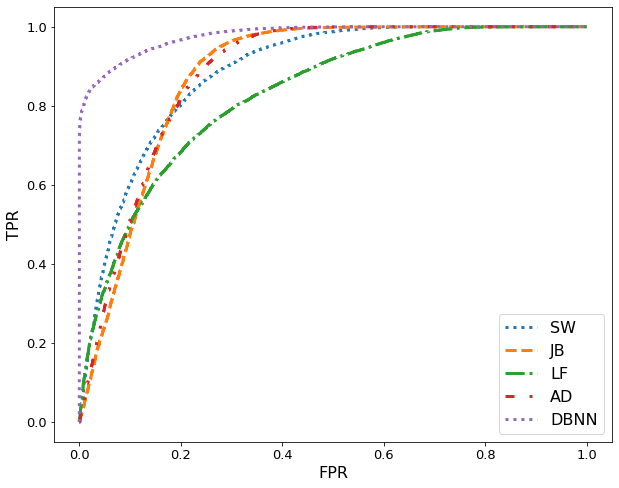

In [42]:
samples = datasets['D']['samples']
labels = datasets['D']['labels']

fig = plt.figure(figsize=(10, 7))
styles = ['dotted', 'dashed', 'dashdot', (0, (3, 5, 1, 5, 1, 5))] 
styles = styles * 3

statistics = {
    code[0] : classifiers[code].calculate_statistic for code in classifiers if 'IB' not in code[0]
}

del statistics['DBNN_1']
del statistics['DBNN_0']

fig = plt.figure(figsize=(10, 8))

for clf_code in statistics:
    print(clf_code)

    statistic_function = statistics[clf_code]
    scores = statistic_function(samples)
    #np.array([statistic_function(sample) for sample in samples])
    if clf_code in ['LF', 'JB', 'AD']:
        scores = -scores
    #auroc = draw_roc_curve(scores, labels, 1, points=1000, label=clf_code, style=styles.pop(0))
    mask = np.isfinite(np.array(scores))
    
    filtered_labels = np.array(labels)[mask]
    filtered_scores = np.array(scores)[mask]
    
    fpr, tpr, tr = sklearn.metrics.roc_curve(filtered_labels, filtered_scores, pos_label=1)
    plt.plot(fpr, tpr, linestyle=styles.pop(0), linewidth=3, label=clf_code)
    aurocs[clf_code] = sklearn.metrics.roc_auc_score(filtered_labels, filtered_scores)

prepared_input = prepare_input(samples, dbnn)
probabilities = dbnn['neural_net'].predict_proba(prepared_input)
scores = probabilities[:, 1]
print('DBNN')
fpr, tpr, tr = sklearn.metrics.roc_curve(labels, scores, pos_label=1)
plt.plot(fpr, tpr, linestyle=styles.pop(0), linewidth=3, label='DBNN')
aurocs['DBNN'] = sklearn.metrics.roc_auc_score(labels, scores)

print(aurocs)

plt.xlabel('FPR', fontsize=16)
plt.ylabel('TPR', fontsize=16)
plt.legend(fontsize=16)

## Save

In [ ]:
#reports

In [ ]:
traverse_and_save({ 'dbnn' : {'derived_tests' : reports}},
                  configuration['reports']['directory_path'])